In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

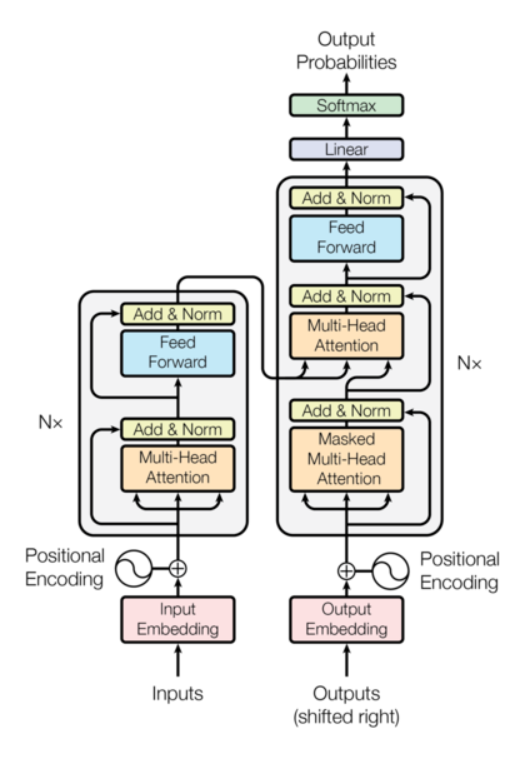

In [2]:
def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

In [3]:
## Encoder

def clones(module, N):
    """
    Produce N identical layers.
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    """
    Encoder is a stack of N layers
    """

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm
    

In [4]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps = 1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.ones(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdims = True)
        std = x.std(-1, keepdims = True)
        return self.a_2*(x - mean)/(std + self.eps) + self.b_2

In [7]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by layer norm 
    Note for code simplicity the norm is first as oppoesed to last
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm  = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer to the same size/
        """
        return x + self.dropout(sublayer(self.norm(x)))

In [8]:
class EncoderLayer(nn.Module):
    """
    Encoder is made up of self-attn and feed forward network
    """

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x =  self.sublayer[0](x, lambda x: self.self_attn(x,x,x. mask))
        return self.sublayer[1](x, self.feed_forward)


